# Twitter Analyser
David Norrish, November 2017

Call Twitter API to retrieve tweets for a user-defined search query, then performs network and sentiment analysis.

## 1. Retrieve tweets
The first step is to call the Twitter tweet search API to retrieve tweets, which we will save in JSON format in a .BZ2 file to save disk space.  
The TwitterAPI has a rich search functionality, with available operators described [here](https://developer.twitter.com/en/docs/tweets/search/guides/standard-operators).

In this example we will specify the search query, language, count of tweets to return, search by recent tweets (as opposed to popular), and define an output file.

In [14]:
# Retrieve tweets and save to an external .bz2 file
from twitter_search import search_tweets

search_query = 'cats'
language = 'en'
count = 300    # the rate limit is 100 tweets per API call, so this will make 3 calls
result_type = 'recent'
file_out = 'cats.txt.bz2'

args = {
    'count': count,
    'lang': language,
    'result_type': result_type,
    'file': file_out
    }

search_tweets(search_query, **args)

Retrieving tweets for query cats...
Total tweets parsed: 100
Total tweets parsed: 200

Retrieved 300 relevant tweets
Saved to file ./tweets/cats.txt.bz2

Remaining API calls for current time period: 176 of 180


## 2. Check data
Check that the API call and data saving worked correctly, browse a few tweets and check for retweet status.  
Note that tweets are saved in JSON, so we can parse them as dictionaries.

In [46]:
import bz2
import json
import networkx as nx

# Import and inspect a BZ2 document of tweets in JSON format
path = './tweets/' + file_out

tweet_file = bz2.BZ2File(path, mode='r')
for i in range(1, 6):
    tweet = json.loads(tweet_file.readline())
    print(str(i) + '. ' + tweet['text'])

1. @SwedishCanary Cats clean themselves without being asked. They also know when to shut up.
2. Why i said yes to being dragged around in to this party idk.

But im happy now 

If anyone neefs me ill be with the cats xD
3. RT @ephemetic: It really breaks my heart to know that there are so many abandoned dogs and cats living on the streets, without food or some…
4. RT @max_fine: Thankful that my cats let me share the bed with them
5. 😅(TRYING!) TO MAKE POKEMON IN CATS &amp; DOGS! 😂 (Sims 4 CAS) - https://t.co/R6Vx6qEpww

So… these are kind of weird! ð… https://t.co/NqvxWtq9RS


When we build the network graph in the next step we'll use retweet status to connect nodes. Let's get a feel for that.

In [76]:
tweet_file.seek(0)    # Return to top of the file

for i in range(6):
    # Extract user id and optional retweeted user id
    tweet = json.loads(tweet_file.readline())
    user_id = tweet['user']['id']
    #if isinstance(user_id, dict):    # sometimes this is returned as a dictionary
    #    user_id = user_id.values()[0]
    user_id = int(user_id)
    print(str(i) + '. User id: {}, '.format(user_id), end = '')
    
    if 'retweeted_status' in tweet:
        retweeted_user_id = tweet['retweeted_status']['user']['id']
        #if isinstance(retweeted_user_id, dict):
        #    retweeted_user_id = retweeted_user_id.values()[0]
        retweeted_user_id = int(retweeted_user_id)
        print('retweeted from: {}'.format(retweeted_user_id))
    else:
        print('original tweet')

0. User id: 151880739, original tweet
1. User id: 808000369, original tweet
2. User id: 742984284, retweeted from: 928713777981415424
3. User id: 749881270755332096, retweeted from: 62310716
4. User id: 920997696747528192, original tweet
5. User id: 283719727, original tweet


As we can see, there is often a rich mix of original and re-tweets. Let's see if there are any major players being retweeted.

In [81]:
tweet_file.seek(0)    # Return to top of the file

retweetees = {}

for line in tweet_file:
    tweet = json.loads(tweet_file.readline())
    if 'retweeted_status' in tweet:
        retweeted_user_id = tweet['retweeted_status']['user']['id']
        if retweeted_user_id not in retweetees:
            retweetees[retweeted_user_id] = 1
        else:
            retweetees[retweeted_user_id] += 1

top_retweetees = sorted(retweetees.items(), reverse=True, key=lambda x: x[1])
for i in range(8):
    print('ID {}, retweeted {} times'.format(top_retweetees[i][0], top_retweetees[i][1]))

ID 713697544744865793, retweeted 5 times
ID 2892225078, retweeted 3 times
ID 802646542779813889, retweeted 3 times
ID 53757167, retweeted 3 times
ID 245157986, retweeted 3 times
ID 1031530278, retweeted 2 times
ID 845465022046232576, retweeted 2 times
ID 4534277543, retweeted 2 times


Let's find the top 5 most retweeted tweets

## 3. Building Graphs
We will use the excellent networkx package to build a graph, by placing a directed edge from each retweeting user to the user they retweeted. Note that building the graph may take some time depending on how how many tweets are in your dataset.

In [82]:
import networkx as nx
tweet_file.seek(0)

#  Initialise the networkx graph
retweet_graph = nx.DiGraph()

# Go line by line (i.e. tweet by tweet), building graph
for line in tweet_file:
    tweet = json.loads(line)
    
    # Only include tweets that are retweets
    if 'retweeted_status' in tweet:
        # Determine user id
        user_id = tweet['user']['id']
        # if isinstance(user_id, dict):
        #     user_id = user_id.values()[0]
        user_id = int(user_id)
    
        # Determine the retweeted user id
        retweeted_user_id = tweet['retweeted_status']['user']['id']
        # if isinstance(retweeted_user_id, dict):
        #     retweeted_user_id = retweeted_user_id.values()[0]
        # retweeted_user_id = int(retweeted_user_id)
        
        # Add the two nodes in the graph, if not already there
        if user_id not in DG:
            DG.add_node(user_id)
        if retweet_user_id not in DG:
            DG.add_node(retweeted_user_id)
        retweet_graph.add_edge(user_id, retweeted_user_id)

Check the dimensionality of the graph. Twitter graphs are generally very sparse.

In [83]:
nodes = retweet_graph.number_of_nodes()
edges = retweet_graph.number_of_edges()
print('Number of nodes: {}'.format(nodes))
print('Number of edges: {}'.format(edges))
max_edges = int(nodes * (nodes - 1))
print('\nGiven that the maximum number of edges in an undirected graph is {} (N * (N - 1)),\nthis graph is {:.1%} connected'.format(max_edges, edges / max_edges))

Number of nodes: 222
Number of edges: 141

Given that the maximum number of edges in an undirected graph is 49062 (N * (N - 1)),
this graph is 0.3% connected


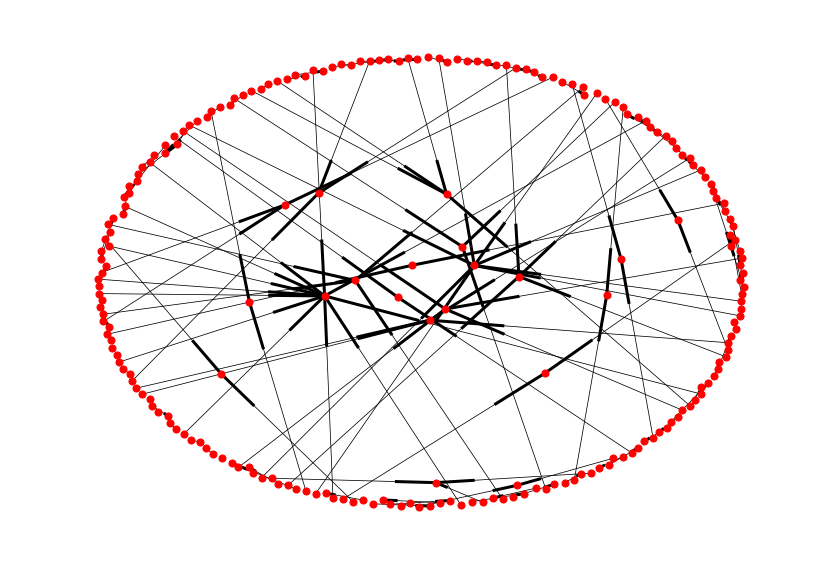

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

# Determine the spring layout
pos = nx.spring_layout(retweet_graph)

# draw the graph
plt.figure(figsize=(14,10))
plt.axis('off')
nx.draw_networkx_nodes(retweet_graph, pos, node_size=50)
nx.draw_networkx_edges(retweet_graph, pos, width=0.75, arrows=True)

### Reply graph
We can also construct the reply graph. First check what replies look like

In [68]:
# Get an example tweet which replies to a user in order to see the structure
tweet_file.seek(0)

# Read through tweets until find an example, see what it looks like
example_found = False
i = 0
while not example_found:
    tweet = json.loads(tweet_file.readline())
    if 'in_reply_to_user_id' in tweet and tweet['in_reply_to_user_id'] != None:
        example_found = True
    i += 1

print(str(i) + '. User ID: ' + str(tweet['user']['id']) + ', in reply to ' + str(tweet['in_reply_to_user_id']))

1. User ID: 151880739, in reply to 53757167


And how many replies we expect:

In [93]:
tweet_file.seek(0)
reply_graph = nx.DiGraph()

## code for constructing the Directed Graph `DG`
# Parse the JSON tweet object and extract information:
# user/id
# go line by line (ergo, tweet by tweet), building graph
for line in tweet_file:
    # load the JSON object from the read line
    tweet = json.loads(line)
    
    # If the current tweet is a reply
    if 'in_reply_to_user_id' in tweet:
        user_id = tweet['user']['id']
        # if isinstance(user_id, dict):
        #     user_id = user_id.values()[0]
        # user_id = int(user_id)
    
        # Determine the replied to user id
        in_reply_to_user_id = jobj['in_reply_to_user_id']
        # if isinstance(in_reply_to_user_id, dict):
        #     in_reply_user_id = in_reply_user_id.values()[0]
        # in_reply_user_id = int(in_reply_user_id)
       
        # Add the two nodes in the graph, if not already there
        if user_id not in reply_graph:
            reply_graph.add_node(user_id)
        if in_reply_to_user_id not in reply_graph:
            reply_graph.add_node(in_reply_to_user_id)
        reply_graph.add_edge(user_id, in_reply_to_user_id)

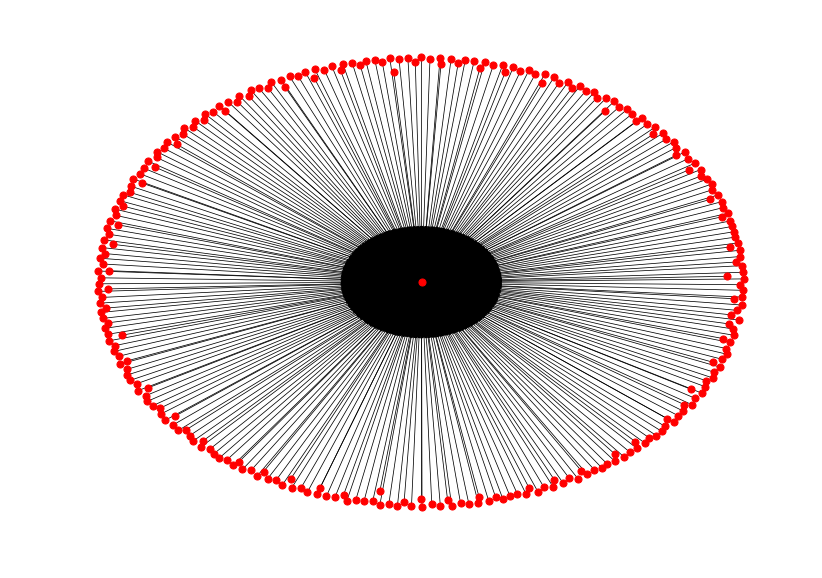

In [94]:
# Determine the spring layout
pos = nx.spring_layout(reply_graph)

# draw the graph
plt.figure(figsize=(14,10))
plt.axis('off')
nx.draw_networkx_nodes(reply_graph, pos, node_size=50)
nx.draw_networkx_edges(reply_graph, pos, width=0.75, arrows=True)